In [1]:
import matplotlib.pyplot as plt
from random import choice
from log_reg_util import one_hot, one_cold, softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from math import exp, log
import numpy as np

In [2]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
from sklearn.datasets import load_digits

class DigitPerceptron:
    
#     def __init__(self, learning_rate: float, input_size: int, output_size: int, hidden_layers_config: list):
## TODO: create Neural Network with configurable hidden layers -> list of sizes, each index specifying the hidden layer size
    
    def __init__(self, learning_rate: float, hidden_size: int):
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        
        self.losses = list()
        self.accuracies = list()
        
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.target = None
        self.target_names = None
        self.images = None
        self._prepare_data()
        
        self.input_size = self.X_train.shape[1]
        self.output_size = self.y_train.shape[1]
        
        self._Wh = np.random.uniform(size=(self.input_size, self.hidden_size), high=0.01, low=-0.01) 
        self._bh = np.zeros(self.hidden_size)
        self._Wo = np.random.uniform(size=(self.hidden_size, self.output_size), high=0.01, low=-0.01)
        self._bo = np.zeros(self.output_size)
        
        self.hot_predictions = None
        
    def _prepare_data(self):
        digits = load_digits()
        data = digits['data']
        self.images = digits['images']
        self.target = digits['target']
        self.target_names = digits['target_names']

        self.hot_target = np.array(self._hot_encode(self.target, self.target_names))
        self.X_train, self.X_test, self.y_train, self.y_test = map(np.array, train_test_split(data, self.hot_target))
    
    def single_epoch_train(self, learning_rate = None, acc_loss = True):
        learning_rate = self.learning_rate if learning_rate is None else learning_rate

        losses = []
        if acc_loss:
            self.accuracies = list()
            self.losses = list()
            
        for i, (x_, y_) in enumerate(zip(self.X_train, self.y_train)):
            grad_W_h, grad_b_h, grad_W_o, grad_b_o, loss = self._train_forward_backward(x_, y_)
            self._Wh = self._Wh - learning_rate * grad_W_h
            self._bh = self._bh - learning_rate * grad_b_h
            self._Wo = self._Wo - learning_rate * grad_W_o
            self._bo = self._bo - learning_rate * grad_b_o

            losses.append(loss)
            
            if acc_loss:
                self.hot_predictions = self.predict(self.X_test)
                acc = self._accuracy(self._cold_encode(self.y_test), self.hot_predictions)
                self.accuracies.append(acc)
                self.losses.append(loss)
              
        return np.mean(losses)
    
    def multiple_epoch_train(self, n_epochs, learning_rate = None, report_interval = None):
        self.accuracies = list()
        self.losses = list()
        for i in range(n_epochs):

            report = True if (report_interval is not None and i % report_interval == 0) else False

            loss = self.single_epoch_train(learning_rate, acc_loss = False)
            predictions = self.predict(self.X_test)
            acc = self._accuracy(self._cold_encode(self.y_test), predictions)
            self.accuracies.append(acc)
            self.losses.append(loss)

            if report:
                print("=========================================")
                print("Accuracy after training: \t{:.2f}%".format(100*(acc)))
                print("Average loss after training: \t{:.4e}".format(loss))

        self.hot_predictions = self.predict(self.X_test)

        return self.hot_predictions, self.accuracies, self.losses
    
    def predict(self, X_):
        return self._forward_pass(X_)[0]
    
    def plot_training_losses(self):
        plt.plot(range(len(self.losses)), self.losses)
        plt.title("Loss per epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Loss")
        None
    
    def plot_training_accuracies(self):
        plt.plot(range(len(self.accuracies)), self.accuracies)
        plt.title("Accuracy per epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        None
    
    def plot_confusion_matrix(self, title = "Confusion Matrix - Actual vs Predicted digits"):
        cold_true = self._cold_encode(self.y_test)
        cold_pred = self._cold_encode(self.hot_predictions)

        conf = confusion_matrix(cold_true, cold_pred)
        
        plt.imshow(conf, interpolation='nearest', cmap=plt.cm.RdBu)
        plt.colorbar()
        tick_marks = self.target_names
        plt.xticks(self.target_names, self.target_names)
        plt.yticks(self.target_names, self.target_names)
        plt.ylabel("True Labels")
        plt.xlabel("Predicted Labels")
        plt.title(title)
        # TODO: add count of each digit in test set
        None
    
    def _forward_model(self, W_, x_, b_):
        return x_.dot(W_) + b_
    
    def _forward_pass(self, x_):
        z_h = self._forward_model(self._Wh, x_, self._bh)
        h = np.apply_along_axis(self._sigmoid, 0, z_h)
        z_o = self._forward_model(self._Wo, h, self._bo)
        y = np.apply_along_axis(self._softmax, 0, z_o)
        return y, h, z_h, z_o
            
    def _train_forward_backward(self, x_, y_hot):
        y, h, z_h, _ = self._forward_pass(x_)

        #     grad_z_o = (y - y_hot) * self._dsigmoid(y)
        grad_z_o = y - y_hot
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o

        grad_h = np.dot(grad_z_o, np.transpose(self._Wo))
        grad_z_h = grad_h * self._dsigmoid(z_h)
        grad_W_h = np.outer(x_, grad_z_h)
        grad_b_h = grad_z_h

        loss = self._nll_alt(y_hot, y)
        return grad_W_h, grad_b_h, grad_W_o, grad_b_o, loss
    
    def _softmax(self, vec):
        vec_exp = np.exp(vec)
        return vec_exp/np.sum(vec_exp)

    def _hot_encode(self, targets_, target_names_):
        encode = lambda x: [1 if i == x else 0 for i in range(len(target_names_))]
        return list(map(encode, targets_))
    
    def _cold_encode(self, hot):
        return np.apply_along_axis(np.argmax, 1, hot)
    
    def _accuracy(self, y_true, y_hot):
        # Compute accuracy for samples X with true labels y
        y_preds = np.argmax(y_hot, axis=1)
        return np.mean(np.equal(y_preds, y_true))
    
    def _nll_alt(self, y_true, y_pred):
        EPSILON = 1e-10
        y_true, y_pred = np.atleast_2d(y_true), np.atleast_2d(y_pred)
        loglikelihoods = np.sum(np.log(EPSILON + y_pred) * y_true, axis=1)
        return -np.mean(loglikelihoods)

    def _sigmoid(self, val, threshold=0.5):
        """ Sigmoid function implementation """
        return 1/(1 + np.exp(-val))

    def _dsigmoid(self, val, threshold=0.5):
        """ Element-wise derivative of sigmoid function """
        sig = self._sigmoid(val, threshold)
        return sig * (1-sig)

---

### Training over single and multiple epochs

In [4]:
perceptron = DigitPerceptron(0.001, 10)

Single Epoch

In [5]:
_ = perceptron.single_epoch_train()

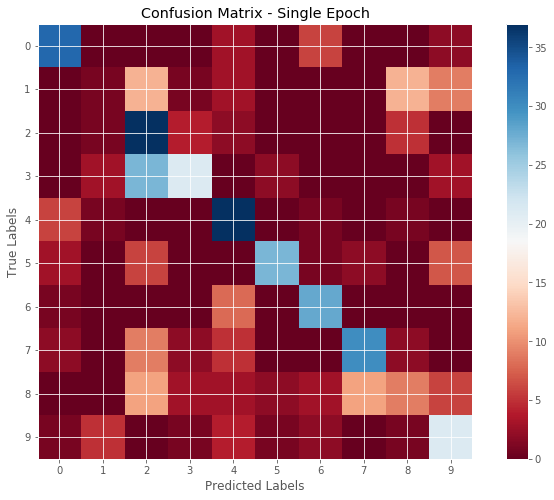

In [6]:
perceptron.plot_confusion_matrix("Confusion Matrix - Single Epoch")

---

Multiple Epochs

In [7]:
preds, _, _ = perceptron.multiple_epoch_train(35, report_interval = 7)

Accuracy after training: 	55.78%
Average loss after training: 	2.2919e+00
Accuracy after training: 	78.44%
Average loss after training: 	1.6274e+00
Accuracy after training: 	85.78%
Average loss after training: 	1.1043e+00
Accuracy after training: 	88.44%
Average loss after training: 	7.9591e-01
Accuracy after training: 	90.44%
Average loss after training: 	6.1497e-01


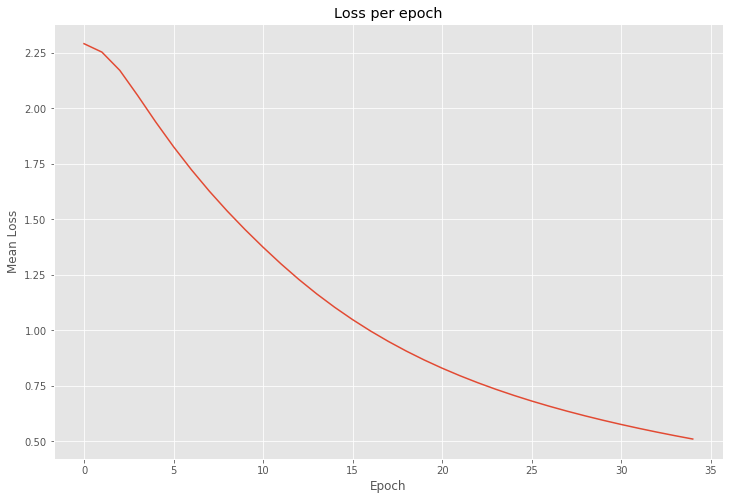

In [8]:
perceptron.plot_training_losses()

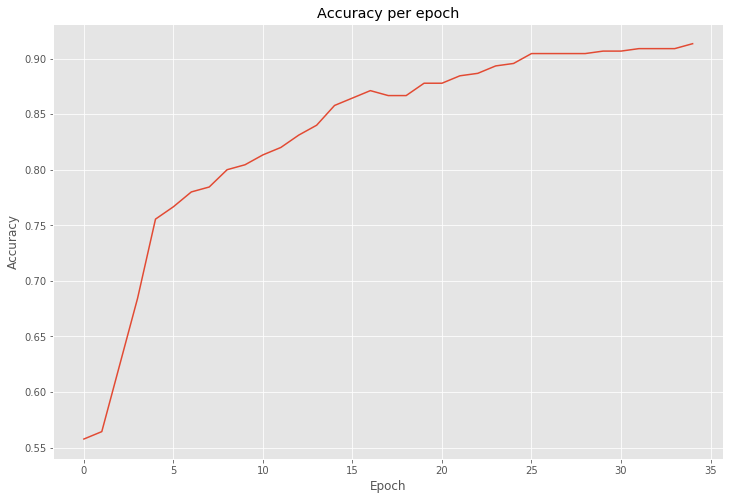

In [9]:
perceptron.plot_training_accuracies()

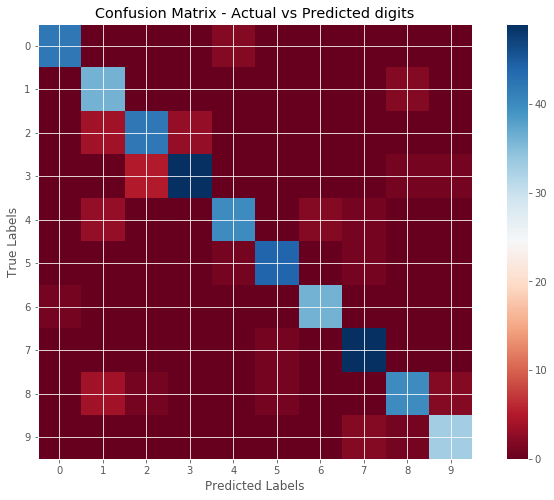

In [10]:
perceptron.plot_confusion_matrix()

---

### Training Single and Multiple Epochs - larger hidden layer

In [11]:
perceptron = DigitPerceptron(0.001, 50)

Single Epoch

In [12]:
perceptron.single_epoch_train()

2.298407181191323

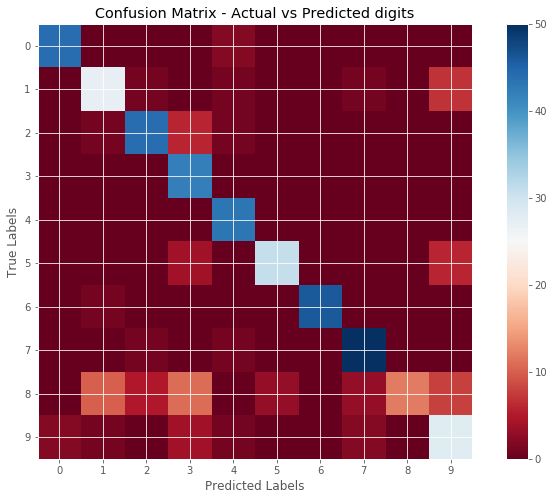

In [13]:
perceptron.plot_confusion_matrix()

Multiple epochs

In [14]:
_, _, _ = perceptron.multiple_epoch_train(10, report_interval=2)

Accuracy after training: 	73.11%
Average loss after training: 	2.2436e+00
Accuracy after training: 	78.00%
Average loss after training: 	1.7357e+00
Accuracy after training: 	85.78%
Average loss after training: 	1.1971e+00
Accuracy after training: 	88.22%
Average loss after training: 	8.5510e-01
Accuracy after training: 	90.44%
Average loss after training: 	6.4012e-01


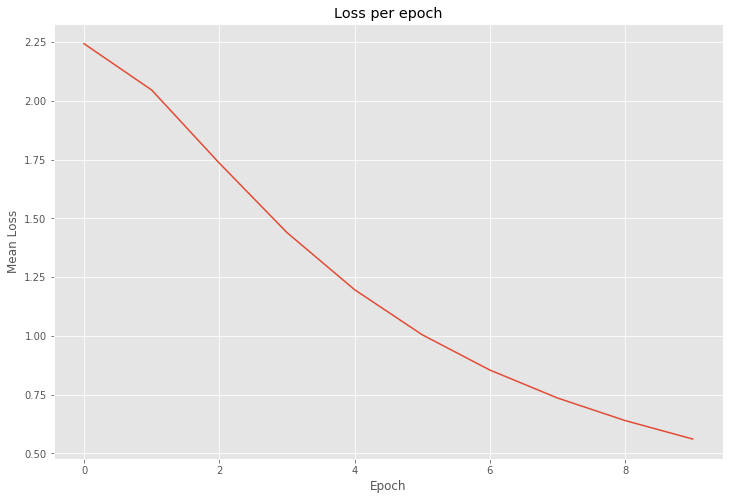

In [15]:
perceptron.plot_training_losses()

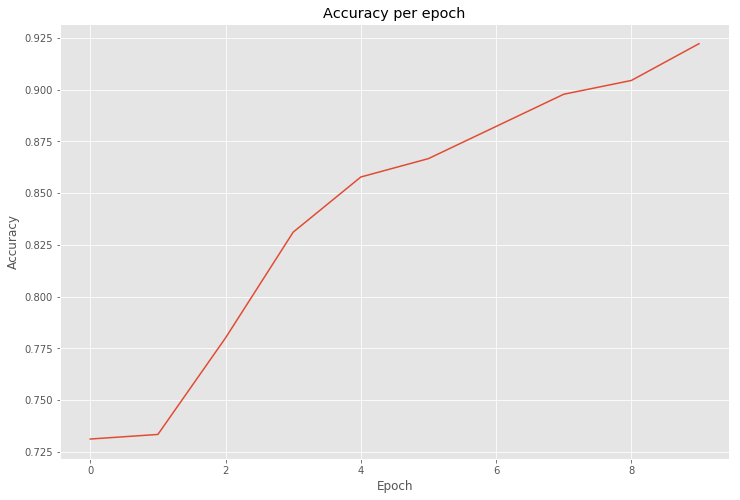

In [16]:
perceptron.plot_training_accuracies()

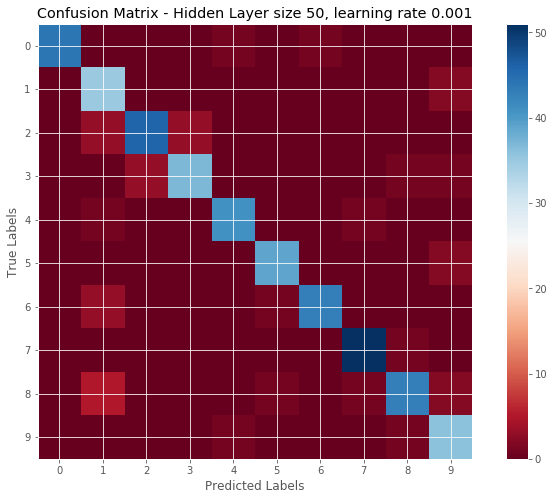

In [17]:
perceptron.plot_confusion_matrix("Confusion Matrix - Hidden Layer size 50, learning rate 0.001")

---

### Training Multiple Epochs - vary the learning rate

In [22]:
perceptron = DigitPerceptron(0.01, 10)

In [24]:
_, _, _ = perceptron.multiple_epoch_train(35, report_interval = 7)

Accuracy after training: 	92.67%
Average loss after training: 	1.2171e-01
Accuracy after training: 	92.44%
Average loss after training: 	7.0937e-02
Accuracy after training: 	92.44%
Average loss after training: 	6.5366e-02
Accuracy after training: 	92.89%
Average loss after training: 	4.9517e-02
Accuracy after training: 	92.00%
Average loss after training: 	4.4800e-02


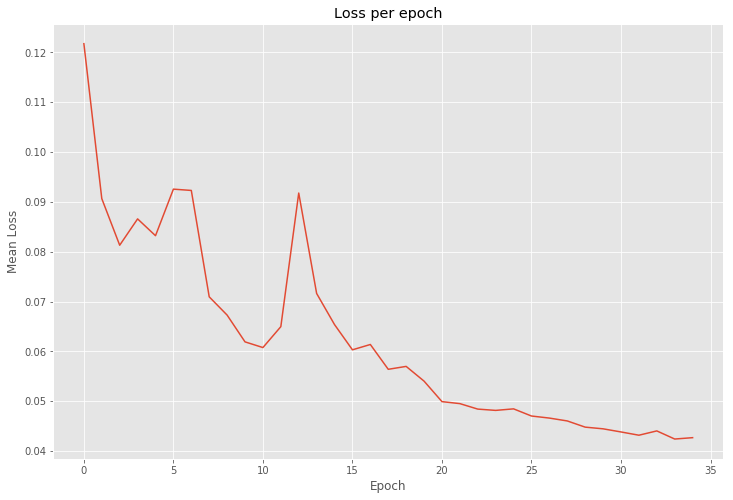

In [25]:
perceptron.plot_training_losses()

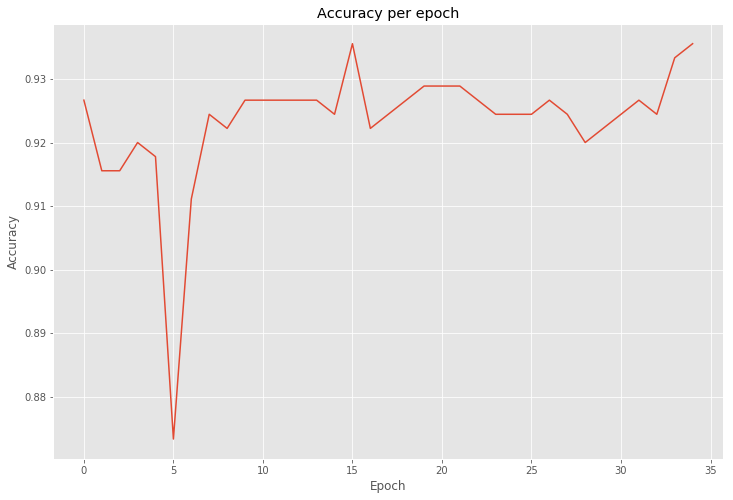

In [26]:
perceptron.plot_training_accuracies()

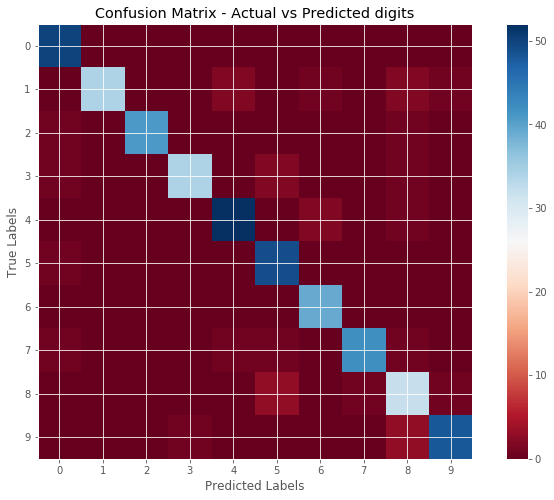

In [27]:
perceptron.plot_confusion_matrix()

---

In [28]:
perceptron = DigitPerceptron(0.0001, 10)

In [29]:
_, _, _ = perceptron.multiple_epoch_train(35, report_interval = 7)

Accuracy after training: 	4.89%
Average loss after training: 	2.3026e+00
Accuracy after training: 	44.00%
Average loss after training: 	2.2997e+00
Accuracy after training: 	55.56%
Average loss after training: 	2.2929e+00
Accuracy after training: 	56.89%
Average loss after training: 	2.2729e+00
Accuracy after training: 	58.89%
Average loss after training: 	2.2288e+00


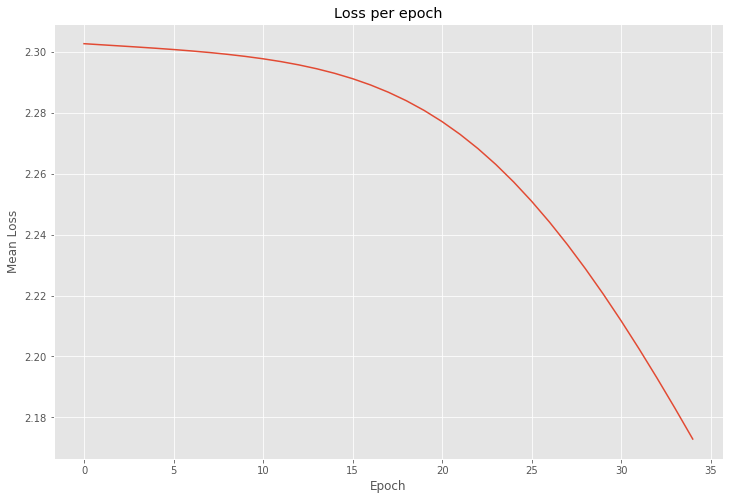

In [30]:
perceptron.plot_training_losses()

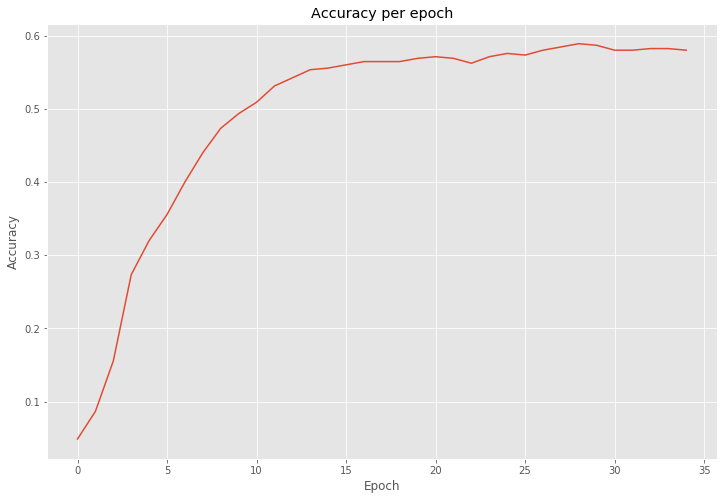

In [31]:
perceptron.plot_training_accuracies()

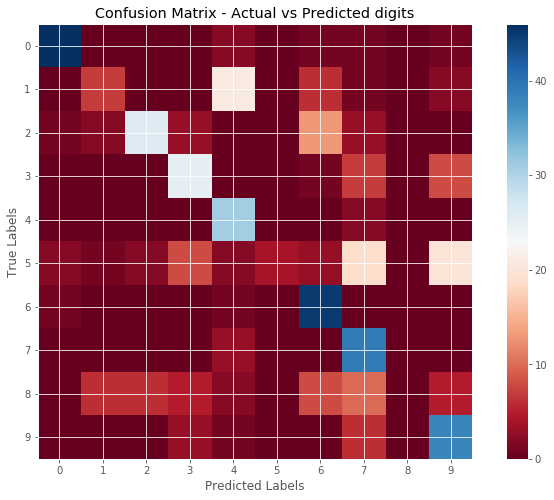

In [32]:
perceptron.plot_confusion_matrix()

---